In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dense, Dropout, concatenate, GlobalAveragePooling2D
import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from sklearn.preprocessing import LabelEncoder


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Concatenate
from sklearn.preprocessing import LabelEncoder

# paths to dataset
source_folder = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/source_folder"
train_dir = os.path.join(source_folder, "train")
test_dir = os.path.join(source_folder, "test")

# Image ke parameters
IMG_SIZE = (224, 224)  # VGG19 ka input size
BATCH_SIZE = 32

# Step 1: Load VGG19 for feature extraction
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)  # Extract features from block5_pool
vgg19_model.trainable = False

# Step 2: Load and preprocess data
def load_data(directory):
    data, labels = [], []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)  # Preprocess the image for VGG19
                data.append(img_array)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# Load train and test data from the respective directories
train_data, train_labels = load_data(train_dir)
test_data, test_labels = load_data(test_dir)

# Encode labels as integers (ASD=0, TD=1)
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)  # Converts labels to 0 and 1
test_labels = label_encoder.transform(test_labels)        # Converts labels to 0 and 1

# Step 3: Extract features using VGG19
train_features = vgg19_model.predict(train_data, batch_size=BATCH_SIZE, verbose=1)
test_features = vgg19_model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)

# Step 4: Define the Inception V1 architecture

def inception_block(x, filters):
    # 1x1 Convolution
    branch1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 1x1 Convolution followed by 3x3 Convolution
    branch2 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    branch2 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(branch2)

    # 1x1 Convolution followed by 5x5 Convolution
    branch3 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    branch3 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(branch3)

    # 3x3 MaxPooling followed by 1x1 Convolution
    branch4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(branch4)

    # Concatenate all branches
    output = Concatenate(axis=-1)([branch1, branch2, branch3, branch4])
    return output

# Step 5: Build the Inception V1 model

input_layer = Input(shape=(7, 7, 512))  # VGG19 ka output shape (7x7x512)
x = inception_block(input_layer, [64, 128, 128, 32, 32, 32])  # filters Define kiye for the inception block
x = AveragePooling2D(pool_size=(2, 2))(x)  # Pooling after inception block
x = Flatten()(x)  # Flatten to feed into dense layers
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification (ASD=0, TD=1)

inception_model = Model(inputs=input_layer, outputs=x)

# Step 6: Compile the model
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 7: Train the model using the training data
inception_model.fit(
    train_features, train_labels,
    batch_size=BATCH_SIZE,
    epochs=30  # Adjust epochs as needed
)

# Step 8: Evaluate the model on test data
test_loss, test_acc = inception_model.evaluate(test_features, test_labels)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Step 9: Save the model
inception_model.save("/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v1_with_vgg19_features.h5")
print("Model saved as 'inception_v1_with_vgg19_features.h5'")


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 0.5599 - loss: 16.1808
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7407 - loss: 0.6676
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8710 - loss: 0.3310
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9285 - loss: 0.1836
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9334 - loss: 0.1739
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9759 - loss: 0.0842
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9767 - loss: 0.0710
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9757 - loss: 0.0608
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9984 - loss: 0.0288
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9961 - loss: 0.0200
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9955 - loss

Test Accuracy: 94.96%
Model saved as 'inception_v1_with_vgg19_features.h5'


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step
Precision: 0.9375
Recall: 0.9740
F1 Score: 0.9554
Confusion Matrix:
[[114  10]
 [  4 150]]


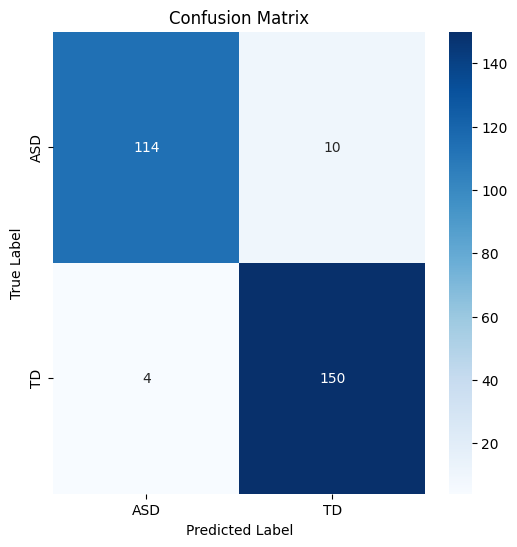

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define paths to dataset
source_folder = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/source_folder"
test_dir = os.path.join(source_folder, "test")

# Image parameters
IMG_SIZE = (224, 224)  # VGG19 input size
BATCH_SIZE = 32

# Step 1: Load VGG19 for feature extraction
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)  # Extract features from block5_pool
vgg19_model.trainable = False

# Step 2: Load and preprocess data for the test set
def load_data(directory):
    data, labels = [], []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)  # Preprocess the image for VGG19
                data.append(img_array)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# Load test data from the directory
test_data, test_labels = load_data(test_dir)

# Encode labels as integers (ASD=0, TD=1)
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)  # Converts labels to 0 and 1

# Step 3: Extract features using VGG19
test_features = vgg19_model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)

# Step 4: Load the saved Inception model from .h5 file
inception_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v1_with_vgg19_features.h5")

# Step 5: Predict labels for the test data
predicted_probs = inception_model.predict(test_features, batch_size=BATCH_SIZE)
predicted_labels = (predicted_probs > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Step 6: Compute precision, recall, F1 score, and confusion matrix
precision = precision_score(test_labels_encoded, predicted_labels)
recall = recall_score(test_labels_encoded, predicted_labels)
f1 = f1_score(test_labels_encoded, predicted_labels)
conf_matrix = confusion_matrix(test_labels_encoded, predicted_labels)

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Step 7: Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


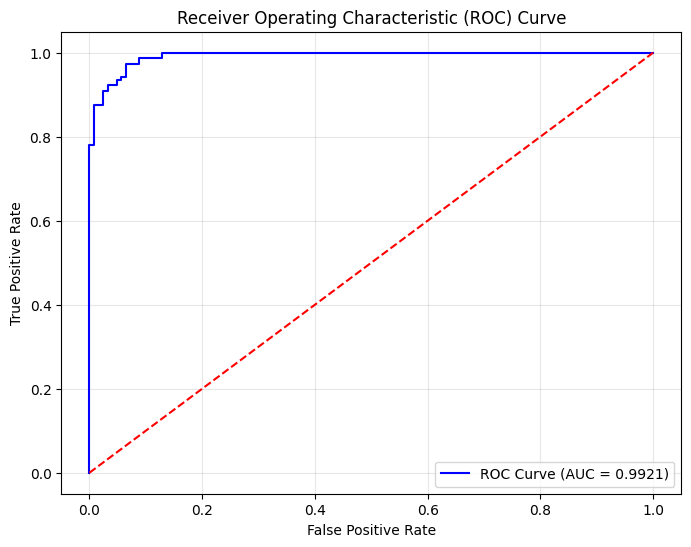

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define paths to dataset
source_folder = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/source_folder"
test_dir = os.path.join(source_folder, "test")

# Image parameters
IMG_SIZE = (224, 224)  # VGG19 input size
BATCH_SIZE = 32

# Step 1: Load VGG19 for feature extraction
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)  # Extract features from block5_pool
vgg19_model.trainable = False

# Step 2: Load and preprocess data for the test set
def load_data(directory):
    data = []  # Initialize data as a list
    labels = []  # Initialize labels as a list
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):  # Ensure it's a folder
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=IMG_SIZE)  # Load the image
                img_array = img_to_array(img)  # Convert to array
                img_array = preprocess_input(img_array)  # Preprocess for VGG19
                data.append(img_array)  # Add image array to data
                labels.append(label)  # Add corresponding label
    data = np.array(data)  # Convert list to numpy array
    labels = np.array(labels)  # Convert list to numpy array
    return data, labels

# Load test data from the directory
test_data, test_labels = load_data(test_dir)

# Encode labels as integers (ASD=0, TD=1)
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)  # Converts labels to 0 and 1

# Step 3: Extract features using VGG19
test_features = vgg19_model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)

# Reshape the features to match the Inception v2 model's input shape
test_features_reshaped = test_features.reshape(test_features.shape[0], 7, 7, 512)

# Step 4: Load the saved Inception v2 model
inception_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v1_with_vgg19_features.h5")

# Step 5: Predict probabilities for the test data
predicted_probs = inception_model.predict(test_features_reshaped, batch_size=BATCH_SIZE)

# Step 6: Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels_encoded, predicted_probs)
roc_auc = auc(fpr, tpr)

# Step 7: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random performance
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# scratch architecture of v1

def InceptionBlock(previous_layer , nbr_f1 , nbr_f2_1 , nbr_f2_2 , nbr_f3_1 , nbr_f3_2 , nbr_f4) :

    #Path 1
    path1 = Conv2D(filters=nbr_f1, kernel_size = (1,1), padding='same' , activation='relu')(previous_layer)

    #Path 2
    path2 = Conv2D(filters=nbr_f2_1, kernel_size = (1,1), padding='same' , activation='relu')(previous_layer)
    path2 = Conv2D(filters=nbr_f2_2, kernel_size = (3,3), padding='same' , activation='relu')(path2)

    #Path 3
    path3 = Conv2D(filters=nbr_f3_1, kernel_size = (1,1), padding='same' , activation='relu')(previous_layer)
    path3 = Conv2D(filters=nbr_f3_1, kernel_size = (5,5), padding='same' , activation='relu')(path3)

    #Path 4
    path4 = MaxPool2D(pool_size=(3,3) , strides=(1,1) , padding='same') (previous_layer)
    path4 = Conv2D(filters=nbr_f4, kernel_size = (1,1), padding='same' , activation='relu')(path4)

    output_Layer = concatenate([path1 , path2 , path3 , path4], axis = -1)

    return output_Layer

def InceptionV1(input_shape):
    input_layer = Input(shape=input_shape)

    # Initial Conv and Pooling layers
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same', activation='relu')(input_layer)
    x = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)  # Reduce stride or padding
    x = Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)  # Same here, adjust stride/padding

    # Inception Blocks
    x = InceptionBlock(previous_layer=x, nbr_f1=64, nbr_f2_1=96, nbr_f2_2=128, nbr_f3_1=16, nbr_f3_2=32, nbr_f4=32)
    x = InceptionBlock(previous_layer=x, nbr_f1=128, nbr_f2_1=128, nbr_f2_2=192, nbr_f3_1=32, nbr_f3_2=96, nbr_f4=64)
    x = MaxPool2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = InceptionBlock(previous_layer=x, nbr_f1=192, nbr_f2_1=96, nbr_f2_2=208, nbr_f3_1=16, nbr_f3_2=48, nbr_f4=64)

    # Average Pooling and Fully Connected layers
    x = AveragePooling2D(pool_size=(5, 5), strides=3)(x)  # Ensure the size is appropriate here
    x = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(1, activation='sigmoid')(x)  # Binary classification output

    # Model definition
    model = Model(inputs=input_layer, outputs=x, name='InceptionV1')
    return model
